In [13]:
# --- added to file ----
# Takes in a String, "bucket_name", a string, "remote_folder",
# and a list of strings or a single string, "keywords". Gets all
# s3 keys for bucket_name/remote_folder. Uses a list convention
# to go through keywords (i.e): ['a', 'b', 'c OR d OR e'] will 
# find all files containing 'a' and 'b' and either 'c', 'd', or 'e'.
# Using '' will return every file key in folder.
def get_s3_keys(bucket_name, remote_folder, keywords=''):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    obj_list = []
    keywords = [i.split('OR') for i in list(keywords)]
    keywords = [list(map(lambda x:x.strip(), i)) for i in keywords]
    for object in bucket.objects.all():
        filename = object.key.split("/")[-1]
        kwds_in = all(any(k in filename for k in ([keyword]*isinstance(keyword, str) or keyword)) for keyword in keywords)
        if remote_folder in object.key and kwds_in:
            obj_list.append(s3.Object(object.bucket_name, object.key))
    return obj_list

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
from os import listdir, getcwd, chdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import csv
import numpy as np
import pandas as pd

In [4]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import csv

# Takes in a path and list of keywords. Returns a list of filenames
# that are within the path that contain one of the keyword in the list.
# Set keyword to "" to get all files in the path.
def get_files(path, keywords = ["features_ OR msd_"]):
    """
    Takes in a path and list of keywords. Returns a list of filenames
    that are within the path that contain one of the keyword in the list.
    Set keyword to "" to get all files in the path.
    """
    keywords = [i.split('OR') for i in list(keywords)]
    keywords = [list(map(lambda x:x.strip(), i)) for i in keywords]
    files = [f for f in listdir(path) if isfile(join(path, f))]
    file_list = []
    for filename in files:
        kwds_in = all(any(k in filename for k in ([keyword]*isinstance(keyword, str) or keyword)) for keyword in keywords)
        if (kwds_in):
            file_list.append(filename)
    return file_list

# Pre: Both files must exhist; Feature must be in the feature file
# Throws a FileNotFoundError exception if preconditions not met
#
# Adds a feature from produced features file to the track file.
def combine_track(trackFile, feature=None, featureDF=None):
    '''
    Adds a feature or set of feature to the corresponding track file
    Preconditions: Both files must exhist; Feature(s) must be in the 
    feature file. 
    
    Input:
    ------
    trackFile : string :
        The file location of the dataframe 
    feature : list : string : tuple :
        feature or set of features to attach to track dataframe
    Output:
    -------
    trackDF : pd.DataFrame :
        DataFrame of the combined tracks
    '''
    if isinstance(trackFile, str):
        try:
            trackDF = pd.read_csv(trackFile)
        except FileNotFoundError:
            raise("DataFrame cannot be located")
    else:
        trackDF = trackFile
    if featureDF is None:
        featureDF = find_pair(trackFile)
    if feature is None:
        feature = np.setdiff1d(featureDF.columns.values, trackDF.columns.values)
    elif isinstance(feature, str):
        feature = [feature]
    elif isinstance(feature, tuple):
        feature = list(feature)
    trackDF = trackDF.reindex(columns=[*trackDF.columns.tolist()] + [*feature], fill_value=np.nan)
    maxFrames = int(trackDF["Frame"].max())
    maxTracks = int(trackDF["Track_ID"].max())
    for i in range(int(maxTracks)+1):
        for feat in feature:
            trackFeature = featureDF.loc[i, feat]
            trackDF.loc[(maxFrames)*(i+1) + i, feat] = trackFeature
    return trackDF

# Trys to find the feature file pair for either the msd_ or Traj_
# Returns the pd.DataFrame of that pair if found.
def find_pair(filename):
    """
    Trys to find the feature file pair for either the msd_ or traj_ df,
    or the Traj_ or msd_ file for input feauture_ file.
    Returns the pd.DataFrame of that pair if found.
    """
    if "msd_" in filename:
        try:
            filename = filename.replace("msd_", "").replace("Traj_", "")
            filename = filename.split("/")
            filename[-1] = "features_" + filename[-1]
            featureFile = "/".join(filename)
            return pd.read_csv(featureFile)
        except FileNotFoundError:
            print("File pair could not be found")  
    elif "features_" in filename:
        try:
            filename = filename.replace("features_", "")
            filename = filename.split("/")
            filename[-1] = "msd_" + filename[-1]
            featureFile = "/".join(filename)
            return pd.read_csv(featureFile)
        except:
            try:
                filename = filename.replace("features_", "")
                filename = filename.split("/")
                filename[-1] = "Traj_" + filename[-1]
                featureFile = "/".join(filename)
                return pd.read_csv(featureFile)
            except FileNotFoundError:
                print("File pair could not be found")

In [95]:
if not 'workbookDir' in globals():
    workbookDir = getcwd()
print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: C:\Users\david\Documents


In [104]:
dataset_path = './raw_data_region_cortex_striatum/'
track_file_list = get_files(dataset_path, keywords=['msd_'])
feature_file_list = get_files(dataset_path, ['features_'])

In [98]:
!pwd

/c/Users/david/Documents/nancework/source/diff_predictor


In [105]:
lengths = []
for filename in feature_file_list:
    tstats = pd.read_csv(dataset_path + '/' + filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
    lengths.append(len(tstats))

In [120]:
np.array(lengths).sum()

100699

In [475]:
fstats_tot = None
video_num = 0
for filename in feature_file_list:
    try:
        fstats = pd.read_csv(dataset_path + '/' + filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        tstats = find_pair(dataset_path + '/' + filename)
        print('{} size: {}'.format(filename, fstats.shape))
        if 'P14' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[14], index=fstats.index)
        elif 'P21' in filename: 
            fstats['age'] = pd.Series(fstats.shape[0]*[21], index=fstats.index)
        elif 'P28' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[28], index=fstats.index)
        elif 'NT_brain_2' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[35], index=fstats.index)
        else:
            print('Error, no target')
        fstats['Video Number'] = pd.Series(fstats.shape[0]*[video_num], index=fstats.index)
        fstats = combine_track(tstats, np.append(feat, ['age']), featureDF=fstats)
        if fstats_tot is None:
            fstats_tot = fstats
        else:
            fstats_tot = fstats_tot.append(fstats, ignore_index=True)
        video_num += 1
    except Exception:
        print('Skipped!: {}'.format(filename))

features_NT_brain_2_slice_1_vid_1.csv size: (416, 23)
features_NT_brain_2_slice_1_vid_2.csv size: (833, 91)
features_NT_brain_2_slice_1_vid_3.csv size: (1017, 91)
features_NT_brain_2_slice_1_vid_4.csv size: (878, 91)
features_NT_brain_2_slice_1_vid_5.csv size: (467, 91)
features_NT_brain_2_slice_2_vid_1.csv size: (2488, 91)
features_NT_brain_2_slice_2_vid_2.csv size: (2322, 91)
features_NT_brain_2_slice_2_vid_3.csv size: (1735, 91)
features_NT_brain_2_slice_2_vid_4.csv size: (1650, 91)
features_NT_brain_2_slice_2_vid_5.csv size: (2100, 91)
features_NT_brain_2_slice_3_vid_1.csv size: (562, 91)
features_NT_brain_2_slice_3_vid_2.csv size: (853, 91)
features_NT_brain_2_slice_3_vid_3.csv size: (817, 91)
features_NT_brain_2_slice_3_vid_4.csv size: (598, 23)
features_NT_brain_2_slice_3_vid_5.csv size: (1062, 91)
features_P14_40nm_s1_v1.csv size: (793, 91)
features_P14_40nm_s1_v2.csv size: (1356, 91)
features_P14_40nm_s1_v3.csv size: (519, 91)
features_P14_40nm_s1_v4.csv size: (140, 91)
featur

In [476]:
# fstats_tot.to_csv('saved_datasets/P14_P21_P28_P32_featuresandtracks.csv')

In [19]:
fstats_tot = pd.read_csv('saved_datasets/P14_P21_P28_P32_featuresandtracks.csv')

In [8]:
feat = np.array(['AR', 'D_fit', 'Deff1', 'Deff2', 'MSD_ratio', 'alpha',
       'asymmetry1', 'asymmetry2', 'asymmetry3', 'boundedness',
       'efficiency', 'elongation', 'fractal_dim', 'frames', 'kurtosis',
       'straightness', 'trappedness'])

In [9]:
def zero_df(df, col, res=(0, 651)):
    '''
    Zeros a single dataframe column so that the first value will be
    located at the start of the track.
    '''
    try:
        shift_val = df.iloc[res[0]:res[1]][col].reset_index().dropna().index[0]
    except:
        shift_val = res[0]-res[1]-1
    return df.iloc[res[0]:res[1]][col].reset_index().shift(-shift_val, fill_value=np.nan)[col]

def get_zeroed_tracks(df, col, res=650):
    '''
    Creates an array of all the tracks for a single column in a file
    in which the value is zeroed to frame = 0
    '''
    lower = 0
    upper = res+1
    value = []
    while (upper <= len(df)):
        value.append(list(zero_df(df, col=col, res=[lower, upper])))
        lower = upper
        upper = lower + res + 1
    return value

In [10]:
import numpy as np
import pandas as pd

# Creates x and y datasets for LSTM based off of input
# track_df data
def get_xy_data(df, target, feat=None, use_feat=False, res=650):
    n_tracks = int((len(df))/(res+1))
    frame = get_zeroed_tracks(df, 'Frame', res=res)
    X = get_zeroed_tracks(df, 'X', res=res)
    Y = get_zeroed_tracks(df, 'Y', res=res)
    MSDs = get_zeroed_tracks(df, 'MSDs', res=res)
    trgt = df[target]
    datax = []
    datay = []
    datafeat = []
    print(n_tracks)
    for j in range(n_tracks):
        trackx = []
        tracky = []
        trackfeat = []
        for i in range(res+1):
            trackx.append([int(frame[j][i]), X[j][i], Y[j][i], MSDs[j][i]])
        datax.append(trackx)
        del(trackx)
        tracky.append(trgt[(res+1)*(j+1)-1])
        datay.append(tracky)
        del(tracky)
        if use_feat is True:
            trackfeat.append(list(df.loc[(res+1)*(j+1)-1, feat]))
        datafeat.append(trackfeat)
        del(trackfeat)
    del(df, frame, X, Y, MSDs, trgt)
    datax = np.array(datax)
    datax = datax.reshape(n_tracks, res+1, 4)
    datay = np.array(datay)
    datay = datay.reshape(n_tracks, 1)
    datafeat = np.array(datafeat)
    datafeat = datafeat.reshape(n_tracks, len(feat))
    result = [datax, datay]
    if use_feat is True:
        result += [datafeat]
    return tuple(result)

In [ ]:
(datax, datay, datafeat) = get_xy_data(fstats_tot, 'age', feat, True)

In [11]:
def get_track(df, track, res):
    return df.loc[(res+1)*(track):(res+1)*(track+1)-1]

def get_feat(df, track, res, feat):
    return df.loc[(res+1)*(track+1)-1, feat]

In [149]:
# np.save('./saved_datasets/RNN_datax', datax)
# np.save('./saved_datasets/RNN_datay', datay)
# np.save('./saved_datasets/RNN_datafeat', datafeat)
datax = np.load('./saved_datasets/RNN_datax.npy')
datay = np.load('./saved_datasets/RNN_datay.npy')
datafeat = np.load('./saved_datasets/RNN_datafeat.npy')

In [15]:
seed = 1010
np.random.seed(seed)
split = 0.8
train_index = np.random.choice(np.arange(0, len(datax)), int(len(datax)*split), replace=False)
test_index = np.setdiff1d(np.arange(0, len(datax)), train_index)
datax = np.nan_to_num(datax, copy=True, nan=-1.0, posinf=-1.0, neginf=-1.0)
datay = np.nan_to_num(datay, copy=True, nan=-1.0, posinf=-1.0, neginf=-1.0)
datafeat = np.nan_to_num(datafeat, copy=True, nan=-1.0, posinf=-1.0, neginf=-1.0)
X_train = datax[train_index]
y_train = datay[train_index]
feat_train = datafeat[train_index]
X_test = datax[test_index]
y_test = datay[test_index]
feat_test = datafeat[test_index]

In [16]:
X_train.shape

(41434, 651, 4)

In [17]:
def numpy_one_hot_encode(mat, encoder=None):
    if encoder is None:
        encoder = np.unique(mat)
    mat = np.array(encoder == mat).astype(int)
    return mat, encoder
y_train, encoder = numpy_one_hot_encode(y_train)
y_test, encoder = numpy_one_hot_encode(y_test, encoder)

In [166]:
def numpy_decode(mat, encoder):
    return np.array([i[i!=0] for i in mat * encoder])
# y_train = numpy_decode(y_train, encoder)
# y_test = numpy_decode(y_test, encoder)

In [18]:
feat_train

array([[ 1.26452152, 14.82302878, -1.        , ...,  1.78059403,
         0.34533962, -0.15742109],
       [ 4.93337269, 12.36510785, -1.        , ...,  7.45517275,
         0.42748064, -0.20779744],
       [ 3.90237424,  1.30709157,  9.18849923, ...,  2.14101599,
         0.80377365, -0.21617611],
       ...,
       [ 2.74396357, 10.80650455, 42.81441741, ...,  2.10793702,
         0.51037026, -0.20056959],
       [ 2.44894041,  9.81796146,  1.53650495, ...,  2.83867407,
         0.16486803, -0.20086897],
       [ 1.61204306, 10.97800038,  2.08129815, ...,  1.88583633,
         0.10717225, -0.19117296]])

In [19]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
(n_timesteps, n_features, n_outputs)

(651, 4, 4)

In [20]:
n_samples, n_feat_size = feat_train.shape
(n_samples, n_feat_size)

(41434, 17)

In [21]:
#Kera libraries
import numpy
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, Concatenate, Flatten, TimeDistributed
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers import SGD


In [128]:
# LSTM without dropout for sequence classification in the IMDB dataset
import numpy
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

def rnn_clsfy(X_train, y_train, n_timesteps, n_features, n_outputs, epochs=15, batch_size=64, verbose=0, **kwargs):
    if 'dropout' not in kwargs:
        dropout = 0.5
    else:
        dropout = kwargs['dropout']
    if 'seed' not in kwargs:
        seed = 123
    else:
        seed = kwargs['seed']
    if 'metrics' not in kwargs:
        metrics = ['accuracy']
    else:
        metrics = kwargs['metrics']
    if 'n_rnnnodes' not in kwargs:
        n_rnnnodes = 100
    else:
        n_rnnnodes = kwargs['n_rnnnodes']
    if 'n_nnnodes' not in kwargs:
        n_rnnnodes = 100
    else:
        n_rnnnodes = kwargs['n_nnnodes']
    if 'reg' not in kwargs:
        reg = L1L2(l1=0.0, l2=0.0)
    else:
        reg = kwargs['reg']
        
    # create the model
    numpy.random.seed(seed)
    model = Sequential()
    model.add(LSTM(n_rnnnodes, input_shape=(n_timesteps, n_features), bias_regularizer=reg, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(n_outputs, activation='softmax'))
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
                                    name='Adam', clipvalue=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)
    print(model.summary())
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.33)
    # Final evaluation:
    score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
    print(f'Accuracy: {score[1]}')
    return model, score





In [ ]:
print(f'{score1[1]}, {score2[1]}, {score3[1]}, {score4[1]}')

In [140]:
split = split
epochs = 50
batch_size = 175
verbose = 0
dropout = 0.0
seed = 10
l1 = 0.40
l2 = 0.50
reg = L1L2(l1=l1, l2=l2)
DATE = 'AUG0220'
name = 'SHACK'

model1, score1 = rnn_clsfy(X_train, y_train, n_timesteps, n_features, n_outputs, epochs=epochs, batch_size=batch_size, verbose=0, dropout=dropout, seed=seed, metrics = ['accuracy'], reg=reg)
model1.save(f'.\saved_models\LSTM_RNN_MODEL_{split}_SPLIT_P14_P21_P28_P35_TARGET_{DATE}_DATE_{epochs}_EPOCHS_{batch_size}_batch_{dropout}_DROPOUT_{l1}_L1_{l2}_L2_{seed}_seed_{name}')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 100)               42000     
_________________________________________________________________
dropout_55 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_232 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_233 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_234 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_235 (Dense)            (None, 4)                 404       
Total params: 72,704
Trainable params: 72,704
Non-trainable params: 0
__________________________________________________

In [126]:
model = load_model('.\saved_models\LSTM_RNN_MODEL_80_20_SPLIT_P14_P21_P28_P35_TARGET_AUG0120_DATE_250_EPOCHS_100_batch_40_DROPOUT_0.00_L1_0.10_L2_100_batch_SHACK')

In [127]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100)               42000     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 404       
Total params: 52,504
Trainable params: 52,504
Non-trainable params: 0
_________________________________________________________________


In [138]:
def rnn_clsfy_aux(X_train, aux_train, y_train, n_timesteps, n_features, n_outputs, n_feat_size, epochs=15, dropout=0.4, batch_size=64, verbose=0, **kwargs):
    if 'dropout' not in kwargs:
        dropout = 0.0
    else:
        dropout = kwargs['dropout']
    if 'seed' not in kwargs:
        seed = 123
    else:
        seed = kwargs['seed']
    if 'metrics' not in kwargs:
        metrics = ['accuracy']
    else:
        metrics = kwargs['metrics']
    if 'n_rnnnodes' not in kwargs:
        n_rnnnodes = 100
    else:
        n_rnnnodes = kwargs['n_rnnnodes']
    if 'reg' not in kwargs:
        reg = L1L2(l1=0.0, l2=0.0)
    else:
        reg = kwargs['reg']

    t_input = Input(shape=(n_timesteps, n_features), dtype='float32', name='TimeSeries')
    aux_input = Input(shape=(n_feat_size), dtype='float32', name='SpatialFeatures')
    
    lstm = LSTM(n_rnnnodes, bias_regularizer=reg, return_sequences=False)(t_input) # First LSTM value
    drpout = Dropout(dropout)(lstm)
    dense = Dense(100, activation='tanh')(drpout)
    
    input_2 = Dense(100, activation='sigmoid')(aux_input)
    
    merge = Concatenate()([dense, input_2]) # add merge 1 here
    
    
    hidden = Dense(100, activation='sigmoid')(merge)
    hidden = Dense(100, activation='sigmoid')(hidden)
    hidden = Dense(100, activation='sigmoid')(hidden)
    hidden = Dense(100, activation='sigmoid')(hidden)
    output = Dense(n_outputs, activation='softmax')(hidden)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
                                    name='Adam', clipvalue=0.1)
    
    model = Model(inputs=[t_input, aux_input], outputs = output)
    model.compile(loss='kullback_leibler_divergence', optimizer=opt, metrics=metrics)
    print(model.summary())
    model.fit([X_train, aux_train], y_train, epochs=epochs, batch_size=batch_size, validation_split=0.33)
    return model

In [137]:
acc_list = []
model1 = rnn_clsfy_aux(X_train, feat_train, y_train, n_timesteps, n_features, n_outputs, n_feat_size, n_rnnnodes=300, epochs=50, batch_size=150, verbose=0, dropout=0.4, seed=1, metrics = ['accuracy'], reg=L1L2(l1=0.40, l2=0.50))
score = model1.evaluate([X_test, feat_test], y_test, batch_size=100, verbose=0)
print(f'Accuracy: {score[1]}')

Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TimeSeries (InputLayer)         [(None, 651, 4)]     0                                            
__________________________________________________________________________________________________
lstm_53 (LSTM)                  (None, 300)          366000      TimeSeries[0][0]                 
__________________________________________________________________________________________________
dropout_53 (Dropout)            (None, 300)          0           lstm_53[0][0]                    
__________________________________________________________________________________________________
SpatialFeatures (InputLayer)    [(None, 17)]         0                                            
___________________________________________________________________________________________

In [ ]:
model3 = rnn_clsfy_aux(X_train, feat_train, y_train, n_timesteps, n_features, n_outputs, n_feat_size, n_rnnnodes=300, epochs=50, batch_size=150, verbose=0, dropout=0.4, seed=1, metrics = ['accuracy'], reg=L1L2(l1=0.40, l2=0.50))


In [147]:
score = model2.evaluate([X_test, feat_test], y_test, batch_size=100, verbose=0)
print(f'Accuracy: {score[1]}')

Accuracy: 0.5057438015937805


In [148]:
model2.save(f'.\saved_models\LSTM_AUX_RNN_MODEL_{split}_SPLIT_P14_P21_P28_P35_TARGET_{DATE}_DATE_{epochs}_EPOCHS_{150}_batch_{0.4}_DROPOUT_{l1}_L1_{l2}_L2_{seed}_seed_{name}')

INFO:tensorflow:Assets written to: .\saved_models\LSTM_AUX_RNN_MODEL_0.8_SPLIT_P14_P21_P28_P35_TARGET_AUG0220_DATE_50_EPOCHS_150_batch_0.4_DROPOUT_0.4_L1_0.5_L2_10_seed_SHACK\assets


In [218]:
from sklearn import metrics

In [223]:
mod = model2
acc2 = []
for i in range(50):
    seed = 1010
    np.random.seed(seed)
    datax = np.load('./saved_datasets/RNN_datax.npy')
    datay = np.load('./saved_datasets/RNN_datay.npy')
    datafeat = np.load('./saved_datasets/RNN_datafeat.npy')
    split = 0.8
    train_index = np.random.choice(np.arange(0, len(datax)), int(len(datax)*split), replace=False)
    test_val_index = np.setdiff1d(np.arange(0, len(datax)), train_index)
    seed+=i
    np.random.seed(seed)
    test_index = np.random.choice(test_val_index, int(len(test_val_index)*0.25), replace=False)
    datax = np.nan_to_num(datax, copy=True, nan=-1.0, posinf=-1.0, neginf=-1.0)
    datay = np.nan_to_num(datay, copy=True, nan=-1.0, posinf=-1.0, neginf=-1.0)
    datafeat = np.nan_to_num(datafeat, copy=True, nan=-1.0, posinf=-1.0, neginf=-1.0)
    X_train = datax[train_index]
    y_train = datay[train_index]
    feat_train = datafeat[train_index]
    X_test = datax[test_index]
    y_test = datay[test_index]
    feat_test = datafeat[test_index]
    y_test, encoder = numpy_one_hot_encode(y_test, encoder)
#     ypred1 = mod.predict(X_test, batch_size = 100)
    ypred1 = mod.predict([X_test, feat_test], batch_size = 100)
    pred=np.array([x == np.max(x) for x in ypred1]).astype(int)
    y_true = numpy_decode(y_test, encoder)
    y_pred = numpy_decode(pred, encoder)
    acc2.append(metrics.accuracy_score(y_true, y_pred))
acc2 = np.array(acc2)

In [221]:
acc1.mean()

0.4991425260718424

In [222]:
acc1.std()

0.01080506083180325

In [227]:
acc1

array([0.48821939, 0.50405562, 0.50714562, 0.50405562, 0.49092314,
       0.50019312, 0.49903438, 0.51178061, 0.49324063, 0.50521437,
       0.50560062, 0.5210506 , 0.50444187, 0.51062186, 0.51371186,
       0.49285438, 0.49826188, 0.47315566, 0.49555813, 0.49517188,
       0.49864813, 0.48744689, 0.50521437, 0.50289687, 0.49092314,
       0.50521437, 0.48551564, 0.51448436, 0.4789494 , 0.48397065,
       0.50753187, 0.49439938, 0.49710313, 0.48783314, 0.49748938,
       0.49517188, 0.48010815, 0.5195056 , 0.50019312, 0.49710313,
       0.48010815, 0.51564311, 0.50251062, 0.50289687, 0.5171881 ,
       0.51255311, 0.50057937, 0.49169564, 0.49092314, 0.49903438])

In [224]:
acc2.mean()

0.506882966396292

In [225]:
acc2.std()

0.009287173461871377

In [226]:
acc2

array([0.50057937, 0.50830436, 0.50405562, 0.51371186, 0.49130939,
       0.49826188, 0.50869061, 0.51602935, 0.50289687, 0.51487061,
       0.51911935, 0.5225956 , 0.51139436, 0.5195056 , 0.51448436,
       0.50598687, 0.51834685, 0.48667439, 0.49942063, 0.50212437,
       0.50482812, 0.50096562, 0.5187331 , 0.51216686, 0.49671688,
       0.50984936, 0.49980688, 0.51834685, 0.48860564, 0.50366937,
       0.50560062, 0.49517188, 0.50289687, 0.50753187, 0.49748938,
       0.50714562, 0.48976439, 0.51564311, 0.5179606 , 0.50212437,
       0.49903438, 0.51834685, 0.50791812, 0.50444187, 0.52375435,
       0.52298185, 0.50869061, 0.50444187, 0.49594438, 0.50521437])

In [287]:
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 100)               42000     
_________________________________________________________________
dropout_55 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_232 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_233 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_234 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_235 (Dense)            (None, 4)                 404       
Total params: 72,704
Trainable params: 72,704
Non-trainable params: 0
__________________________________________________

In [288]:
print(model2.summary())

Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TimeSeries (InputLayer)         [(None, 651, 4)]     0                                            
__________________________________________________________________________________________________
lstm_47 (LSTM)                  (None, 300)          366000      TimeSeries[0][0]                 
__________________________________________________________________________________________________
dropout_47 (Dropout)            (None, 300)          0           lstm_47[0][0]                    
__________________________________________________________________________________________________
dense_188 (Dense)               (None, 100)          30100       dropout_47[0][0]                 
___________________________________________________________________________________________

In [228]:
accs = [[0.48821939, 0.50405562, 0.50714562, 0.50405562, 0.49092314,
         0.50019312, 0.49903438, 0.51178061, 0.49324063, 0.50521437,
         0.50560062, 0.5210506 , 0.50444187, 0.51062186, 0.51371186,
         0.49285438, 0.49826188, 0.47315566, 0.49555813, 0.49517188,
         0.49864813, 0.48744689, 0.50521437, 0.50289687, 0.49092314,
         0.50521437, 0.48551564, 0.51448436, 0.4789494 , 0.48397065,
         0.50753187, 0.49439938, 0.49710313, 0.48783314, 0.49748938,
         0.49517188, 0.48010815, 0.5195056 , 0.50019312, 0.49710313,
         0.48010815, 0.51564311, 0.50251062, 0.50289687, 0.5171881 ,
         0.51255311, 0.50057937, 0.49169564, 0.49092314, 0.49903438],
        [0.50057937, 0.50830436, 0.50405562, 0.51371186, 0.49130939,
         0.49826188, 0.50869061, 0.51602935, 0.50289687, 0.51487061,
         0.51911935, 0.5225956 , 0.51139436, 0.5195056 , 0.51448436,
         0.50598687, 0.51834685, 0.48667439, 0.49942063, 0.50212437,
         0.50482812, 0.50096562, 0.5187331 , 0.51216686, 0.49671688,
         0.50984936, 0.49980688, 0.51834685, 0.48860564, 0.50366937,
         0.50560062, 0.49517188, 0.50289687, 0.50753187, 0.49748938,
         0.50714562, 0.48976439, 0.51564311, 0.5179606 , 0.50212437,
         0.49903438, 0.51834685, 0.50791812, 0.50444187, 0.52375435,
         0.52298185, 0.50869061, 0.50444187, 0.49594438, 0.50521437],
        [0.55100049, 0.54367984, 0.54742151, 0.54693346, 0.54807223,
         0.5457947 , 0.54075159, 0.53570848, 0.54026354, 0.54156499,
         0.54807223, 0.54823491, 0.54725883, 0.53749797, 0.55360338,
         0.54725883, 0.5397755 , 0.55897186, 0.54286644, 0.54693346,
         0.55148853, 0.55116317, 0.53879941, 0.54888564, 0.54856027,
         0.54742151, 0.53619652, 0.54449325, 0.54514397, 0.54709614,
         0.54042622, 0.55116317, 0.54189035, 0.54335448, 0.53733529,
         0.54872295, 0.54725883, 0.54367984, 0.54986172, 0.54725883,
         0.55100049, 0.54270376, 0.54270376, 0.54774687, 0.54969904,
         0.54433057, 0.54286644, 0.54546933, 0.54742151, 0.54286644],
        [0.52968928, 0.53196681, 0.53261754, 0.5329429 , 0.53554579,
         0.53261754, 0.5295266 , 0.52301936, 0.53391898, 0.52838783,
         0.52838783, 0.53505775, 0.53245486, 0.52367008, 0.54140231,
         0.53131609, 0.53017732, 0.54107695, 0.52936392, 0.53034   ,
         0.53766065, 0.53749797, 0.52562225, 0.54091427, 0.53619652,
         0.54107695, 0.52155523, 0.52773711, 0.52741175, 0.54058891,
         0.52562225, 0.53814869, 0.53619652, 0.52757443, 0.51846429,
         0.53456971, 0.5329429 , 0.52545957, 0.53863673, 0.53456971,
         0.53684724, 0.53310558, 0.53066537, 0.53391898, 0.53131609,
         0.52659834, 0.53229218, 0.53001464, 0.53798601, 0.52659834]]

Text(0.5, 1.0, 'Accuracy Performance of Predictive Models')

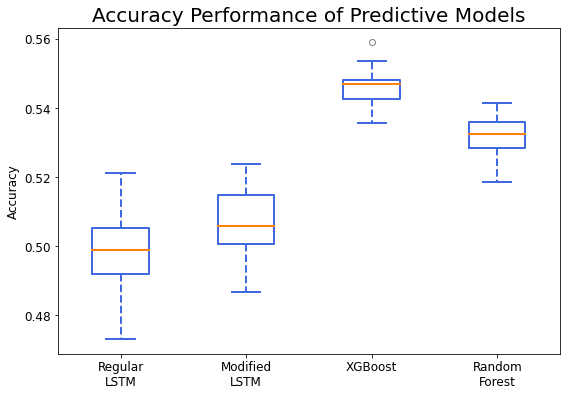

In [282]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# figure = plt.figure(figsize=(10,8))
# Make the figures big enough for the optically challenged.
#pylab.rcParams['figure.figsize'] = (10.0, 8.0)
# We start by making a copy of the original data frame, minus the sex attribute.
#replot

# plt.xticks([1, 2, 3, 4], ['Regular\nLSTM', 'Modified LSTM', 'XGBoost', 'Random Forest'],ha='right')

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(accs)

for box in bp['boxes']:
    # change outline color
    box.set(linewidth=2, color='#4169E1')
    # change fill color
#     box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(linewidth=2, color='#4169E1', linestyle='--')

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(linewidth=2, color='#4169E1')

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o',alpha=0.5)
    
ax.set_xticklabels(['Regular\nLSTM', 'Modified\nLSTM', 'XGBoost', 'Random\nForest'])
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.rc('font', size=10)
plt.rc('xtick', labelsize=10)
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

plt.ylabel(("Accuracy"))
plt.title('Accuracy Performance of Predictive Models')

In [181]:
ypred1 = model1.predict(X_test, batch_size=100, verbose=0)
pred=np.array([x == np.max(x) for x in ypred1]).astype(int)

In [162]:
from sklearn.metrics import classification_report

In [283]:
class_names = ['P14', 'P21', 'P28', 'P35']
y_true = numpy_decode(y_test, encoder)
y_pred = numpy_decode(pred, encoder)
class_results = classification_report(y_true, y_pred, digits=4, target_names = ['P14', 'P21', 'P28', 'P35'])
print(str(class_results))

              precision    recall  f1-score   support

         P14     0.3629    0.1461    0.2083       308
         P21     0.5007    0.6540    0.5672      1078
         P28     0.0000    0.0000    0.0000       298
         P35     0.5279    0.6166    0.5688       905

    accuracy                         0.5052      2589
   macro avg     0.3479    0.3542    0.3361      2589
weighted avg     0.4362    0.5052    0.4598      2589



C:\Users\david\.conda\envs\tf-gpu-2\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2572

In [170]:
y_test

array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

In [152]:
np.random.choice(test_index, int(len(test_index)*0.5), replace=False)

array([33153,  6843, 35039, ..., 23063, 29869, 33693])

In [65]:
import matplotlib.pyplot as py

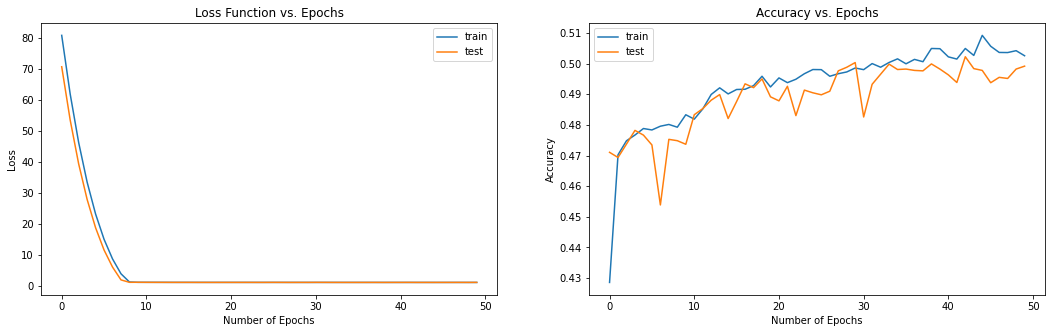

In [145]:
f = py.figure(figsize=(18,5))
ax = f.add_subplot(121)
ax.plot(model1.history.history['loss'], label='train')
ax.plot(model1.history.history['val_loss'], label='test')
ax.legend()
ax.set_ylabel('Loss')
ax.set_xlabel('Number of Epochs')
ax.set_title('Loss Function vs. Epochs')

ax2 = f.add_subplot(122)
ax2.plot(model1.history.history['accuracy'], label='train')
ax2.plot(model1.history.history['val_accuracy'], label='test')
ax2.legend()
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Number of Epochs')
ax2.set_title('Accuracy vs. Epochs')
py.show()

In [ ]:
model.save('.\saved_models\LSTM_RNN_AUX_MODEL_80_20_SPLIT_P14_P21_P28_P35_TARGET_AUG0120_DATE_250_EPOCHS_40_DROPOUT_0.00_L1_0.10_L2_SHACK')

In [ ]:
model = load_model('.\saved_models\LSTM_RNN_AUX_MODEL_80_20_SPLIT_P14_P21_P28_P35_TARGET_AUG0120_DATE_250_EPOCHS_40_DROPOUT_0.00_L1_0.10_L2_SHACK')

In [ ]:
data = pd.DataFrame()
for filename in filenames:
    if tag:
        file_tag = next(tag)
    else:
        file_tag = None
    try:
        file_path = os.path.join(folder, filename)
        print(file_path)
        file_data = pd.read_csv(file_path, encoding = "utf-8", delimiter = 'sep')
        if file_tag:
            size = file_data.shape[0]
            file_data['Tag'] = pd.Series(size*[file_tag], index=file_data.index)
        data = pd.concat([data, file_data])
    except IOError as err:
        print(f'Skipped!: {filename} {err}')

In [13]:
rnn_clsfy(1000, 100)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 100)]        0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 64)      64000       input1[0][0]                     
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 64)      64000       input2[0][0]                     
______________________________________________________________________________________________

In [ ]:
from utils.constants import MAX_NB_VARIABLES, MAX_TIMESTEPS_LIST
from utils.generic_utils import load_dataset_at, calculate_dataset_metrics, cutoff_choice, \
    cutoff_sequence
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import Permute
from keras.models import Model
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)


def multi_label_log_loss(y_pred, y_true):
    return K.sum(K.binary_crossentropy(y_pred, y_true), axis=-1)


def _average_gradient_norm(model, X_train, y_train, batch_size):
    # just checking if the model was already compiled
    if not hasattr(model, "train_function"):
        raise RuntimeError("You must compile your model before using it.")

    weights = model.trainable_weights  # weight tensors

    get_gradients = model.optimizer.get_gradients(
        model.total_loss, weights)  # gradient tensors

    input_tensors = [
        # input data
        model.inputs[0],
        # how much to weight each sample by
        model.sample_weights[0],
        # labels
        model.targets[0],
        # train or test mode
        K.learning_phase()
    ]

    grad_fct = K.function(inputs=input_tensors, outputs=get_gradients)

    steps = 0
    total_norm = 0
    s_w = None

    nb_steps = X_train.shape[0] // batch_size

    if X_train.shape[0] % batch_size == 0:
        pad_last = False
    else:
        pad_last = True

    def generator(X_train, y_train, pad_last):
        for i in range(nb_steps):
            X = X_train[i * batch_size: (i + 1) * batch_size, ...]
            y = y_train[i * batch_size: (i + 1) * batch_size, ...]

            yield (X, y)

        if pad_last:
            X = X_train[nb_steps * batch_size:, ...]
            y = y_train[nb_steps * batch_size:, ...]

            yield (X, y)

    datagen = generator(X_train, y_train, pad_last)

    while steps < nb_steps:
        X, y = next(datagen)
        # set sample weights to one
        # for every input
        if s_w is None:
            s_w = np.ones(X.shape[0])

        gradients = grad_fct([X, s_w, y, 0])
        total_norm += np.sqrt(np.sum([np.sum(np.square(g))
                                      for g in gradients]))
        steps += 1

    if pad_last:
        X, y = next(datagen)
        # set sample weights to one
        # for every input
        if s_w is None:
            s_w = np.ones(X.shape[0])

        gradients = grad_fct([X, s_w, y, 0])
        total_norm += np.sqrt(np.sum([np.sum(np.square(g))
                                      for g in gradients]))
        steps += 1

    return total_norm / float(steps)


def rnn_train_model(model: Model, 
                    train_dataset, 
                    eval_dataset,
                    folds=5, 
                    epochs=50, 
                    batch_size=128, 
                    val_subset=None,
                    cutoff=None,  
                    learning_rate=1e-3, 
                    monitor='loss', 
                    optimization_mode='auto', 
                    compile_model=True):
    
    X_train, y_train, X_test, y_test, is_timeseries = load_dataset_at(dataset_id,
                                                                      fold_index=dataset_fold_id,
                                                                      normalize_timeseries=normalize_timeseries)
    max_timesteps, max_nb_variables = calculate_dataset_metrics(X_train)

    if max_nb_variables != MAX_NB_VARIABLES[dataset_id]:
        if cutoff is None:
            choice = cutoff_choice(dataset_id, max_nb_variables)
        else:
            assert cutoff in [
                'pre', 'post'], 'Cutoff parameter value must be either "pre" or "post"'
            choice = cutoff

        if choice not in ['pre', 'post']:
            return
        else:
            X_train, X_test = cutoff_sequence(
                X_train, X_test, choice, dataset_id, max_nb_variables)
            
    classes = np.unique(y_train)
    le = LabelEncoder()
    y_ind = le.fit_transform(y_train.ravel())
    recip_freq = len(y_train) / (len(le.classes_) *
                                 np.bincount(y_ind).astype(np.float64))
    class_weight = recip_freq[le.transform(classes)]

    print("Class weights : ", class_weight)

    y_train = to_categorical(y_train, len(np.unique(y_train)))
    y_test = to_categorical(y_test, len(np.unique(y_test)))

    if is_timeseries:
        factor = 1./np.cbrt(2)
    else:
        factor = 1./np.sqrt(2)

    if dataset_fold_id is None:
        weight_fn = "./weights/%s_weights.h5" % dataset_prefix
    else:
        weight_fn = "./weights/%s_fold_%d_weights.h5" % (
            dataset_prefix, dataset_fold_id)

    model_checkpoint = ModelCheckpoint(weight_fn, verbose=1, mode=optimization_mode,
                                       monitor=monitor, save_best_only=True, save_weights_only=True)
    reduce_lr = ReduceLROnPlateau(monitor=monitor, patience=100, mode=optimization_mode,
                                  factor=factor, cooldown=0, min_lr=1e-4, verbose=2)
    callback_list = [model_checkpoint, reduce_lr]

    optm = Adam(lr=learning_rate)

    if compile_model:
        model.compile(optimizer=optm,
                      loss='categorical_crossentropy', metrics=['accuracy'])

    if val_subset is not None:
        X_test = X_test[:val_subset]
        y_test = y_test[:val_subset]

    model.fit([X_train, ], y_train, batch_size=batch_size, epochs=epochs, callbacks=callback_list,
              class_weight=class_weight, verbose=2, validation_data=(X_test, y_test))


def evaluate_model(model: Model, dataset_id, dataset_prefix, dataset_fold_id=None, batch_size=128, test_data_subset=None,
                   cutoff=None, normalize_timeseries=False):
    _, _, X_test, y_test, is_timeseries = load_dataset_at(dataset_id,
                                                          fold_index=dataset_fold_id,
                                                          normalize_timeseries=normalize_timeseries)
    max_timesteps, max_nb_variables = calculate_dataset_metrics(X_test)

    if max_nb_variables != MAX_NB_VARIABLES[dataset_id]:
        if cutoff is None:
            choice = cutoff_choice(dataset_id, max_nb_variables)
        else:
            assert cutoff in [
                'pre', 'post'], 'Cutoff parameter value must be either "pre" or "post"'
            choice = cutoff

        if choice not in ['pre', 'post']:
            return
        else:
            _, X_test = cutoff_sequence(
                None, X_test, choice, dataset_id, max_nb_variables)

    if not is_timeseries:
        X_test = pad_sequences(
            X_test, maxlen=MAX_NB_VARIABLES[dataset_id], padding='post', truncating='post')
    y_test = to_categorical(y_test, len(np.unique(y_test)))

    optm = Adam(lr=1e-3)
    model.compile(optimizer=optm, loss='categorical_crossentropy',
                  metrics=['accuracy'])

    if dataset_fold_id is None:
        weight_fn = "./weights/%s_weights.h5" % dataset_prefix
    else:
        weight_fn = "./weights/%s_fold_%d_weights.h5" % (
            dataset_prefix, dataset_fold_id)
    model.load_weights(weight_fn)

    if test_data_subset is not None:
        X_test = X_test[:test_data_subset]
        y_test = y_test[:test_data_subset]

    print("\nEvaluating : ")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
    print()
    print("Final Accuracy : ", accuracy)

    return accuracy, loss


def set_trainable(layer, value):
    layer.trainable = value

    # case: container
    if hasattr(layer, 'layers'):
        for l in layer.layers:
            set_trainable(l, value)

    # case: wrapper (which is a case not covered by the PR)
    if hasattr(layer, 'layer'):
        set_trainable(layer.layer, value)

In [1]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.


In [2]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000

In [3]:
import numpy as np
# save np.load
#np_load_old = np.load

# modify the default parameters of np.load
#np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

# restore np.load for future normal usage
#np.load = np_load_old

In [4]:
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [586]:
import numpy
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
# create the model
embedding_vecor_length = 32
model = tf.keras.Sequential()
# model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Concatenate())([merge1, aux_input])
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 650, 32)           160000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


ValueError: Error when checking input: expected embedding_1_input to have 2 dimensions, but got array with shape (36255, 651, 4)

In [22]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.43%


In [587]:
# LSTM with Dropout for sequence classification in the IMDB dataset
import numpy
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# create the model
embedding_vecor_length = 32
model = tf.keras.Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 17s 664us/sample - loss: 0.47

In [5]:
# LSTM and CNN for sequence classification in the IMDB dataset
import numpy
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers.convolutional import Conv1D
from tensorflow.keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.layers.embeddings import Embedding
from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

ModuleNotFoundError: No module named 'tensorflow.keras.layers.convolutional'

In [ ]:
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [17]:
X_test

array([[   0,    0,    0, ...,   14,    6,  717],
       [   0,    0,    0, ...,  125,    4, 3077],
       [  33,    6,   58, ...,    9,   57,  975],
       ...,
       [   0,    0,    0, ...,   21,  846,    2],
       [   0,    0,    0, ..., 2302,    7,  470],
       [   0,    0,    0, ...,   34, 2005, 2643]], dtype=int32)

In [7]:
# LSTM with Dropout for sequence classification in msd dataset
import numpy
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset b
 z
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

NameError: name 'X_train' is not defined

---

---

In [12]:
import collections
from tensorflow.python.ops.math_ops import tanh


class RNNCell(object):
    def __call__(self, inputs, state, scope=None):
        raise NotImplementedError("Abstract method")
    

class LSTMCell(RNNCell):
    """Basic LSTM recurrent network cell.
    The implementation is based on: http://arxiv.org/abs/1409.2329.
    We add forget_bias (default: 1) to the biases of the forget gate in order to
    reduce the scale of forgetting in the beginning of the training.
    It does not allow cell clipping, a projection layer, and does not
    use peep-hole connections: it is the basic baseline.
    For advanced models, please use the full LSTMCell that follows.
    """  
    def __init__(self, n_units, n_proj=None, forget_bias=0.0, input_size=None, activation=tanh):
        self._n_units  = n_units
        self._n_proj = n_proj
        self._forget_bias = forget_bias
        self._input_size = input_size
        self._activation = activation

        (self._state_size, 
         self._output_size) = ((LSTMStateTuple(n_units, n_proj) , n_units + n_proj)
                            if n_proj else (LSTMStateTuple(n_units, n_units), 2*n_units))

        
    @property
    def state_size(self):
        return self._state_size
    
    
    @property
    def output_size(self):
        return self. _output_size
    
    
    def __call__(self, inputs, state, scope=None):
        
        pass

# class LSTM(LSTM):
    
    
#     def __init__(self, ):
#         pass
    
_LSTMStateTuple = collections.namedtuple("LSTMStateTuple", ("c", "h"))

class LSTMStateTuple(_LSTMStateTuple):
  
    """Tuple used by LSTM Cells for `state_size`, `zero_state`, and output state.
    Stores two elements: `(c, h)`, in that order.
    Only used when `state_is_tuple=True`.
    """
    __slots__ = ()

    @property
    def dtype(self):
        (c, h) = self
        if not c.dtype == h.dtype:
            raise TypeError("Inconsistent internal state: %s vs %s" %
                            (str(c.dtype), str(h.dtype)))
    return c.dtype


In [18]:
x = LSTMCell(50, 20, 1.0, 128)


In [19]:
x.state_size

LSTMStateTuple(c=50, h=20)

In [20]:
x = LSTMCell()

TypeError: __init__() missing 1 required positional argument: 'n_units'